### Siamese NN based whale identification. 
#### This notebook is very completely based on https://github.com/afitts/kaggle/blob/master/competitions/humpback-whale/siamese-with-fast-ai.ipynb for understanding the SNN and its implementation in fastai.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [2]:
import fastai
fastai.__version__

'1.0.57'

In [5]:
path = Path('../data/humpback-whale/')
train = pd.read_csv(path/'train.csv');

In [6]:
## Filtering classes with at least 60 images for quick experiments
cnter = Counter(train.Id.values)
train['cnt']=train['Id'].apply(lambda x: cnter[x])
#Not consider new_whale images and hence considering 500 as upper cutoff
train = train[(train['cnt']>60) & (train['cnt']<500)]

In [7]:
train['target'] = 1
train1 = train.copy()
train1['target'] = 0
train = train.append(train1)
target_col = 3

In [8]:
mean, std = torch.tensor(imagenet_stats)

In [9]:
# The primary difference from the tutorial is with how normalization is being done here
class SiamImage(ItemBase):
    def __init__(self, img1, img2): ## These should of Image type
        self.img1, self.img2 = img1, img2
        self.obj, self.data = (img1, img2), [(img1.data-mean[...,None,None])/std[...,None,None], (img2.data-mean[...,None,None])/std[...,None,None]]
    def apply_tfms(self, tfms,*args, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms, *args, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, *args, **kwargs)
        self.data = [(self.img1.data-mean[...,None,None])/std[...,None,None], (self.img2.data-mean[...,None,None])/std[...,None,None]]
        return self
    def __repr__(self): return f'{self.__class__.__name__} {self.img1.shape, self.img2.shape}'
    def to_one(self):
        return Image(mean[...,None,None]+torch.cat(self.data,2)*std[...,None,None])

In [16]:
class SiamImageItemList(ImageList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
#         self._label_cls=FloatList
    
    def __len__(self)->int: return len(self.items) or 1 
    
    def get(self, i):
        match=1
        if i>=len(self.items)//2:#"First set of iteration will generate similar pairs, next will generate different pairs"
            match = 0
        fn = self.items[i]
        img1 = super().get(i) # Returns Image class object
        
        imgs = self.inner_df.Image.values
        ids = self.inner_df.Id.values
        wcls = ids[i]
        simgs = imgs[ids == wcls]
        dimgs = imgs[ids != wcls]
        if len(simgs)==1 and match==1:
            fn2=fn
        else:
            while True:
                np.random.shuffle(simgs)
                np.random.shuffle(dimgs)
                if simgs[0] != fn:
                    fn2 = [simgs[0] if match==1 else dimgs[0]][0]
                    break
            fn2 = self.items[np.where(imgs==fn2)[0][0]]
        img2 = super().open(fn2) # Returns Image class object
        return SiamImage(img1, img2)
    
    def reconstruct(self, t): return SiamImage(mean[...,None,None]+t[0]*std[...,None,None], mean[...,None,None]+t[1]*std[...,None,None])
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(9,10), **kwargs):
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

In [17]:
whl_tfms = get_transforms()
bs = 8

In [18]:
data = (SiamImageItemList.from_df(df=train, path=path/'train', cols=0)
         .split_by_rand_pct(0.2, seed=34)
         .label_from_df(cols=target_col, label_cls=FloatList)
         .transform(whl_tfms, size=224)
         .databunch(bs=bs))

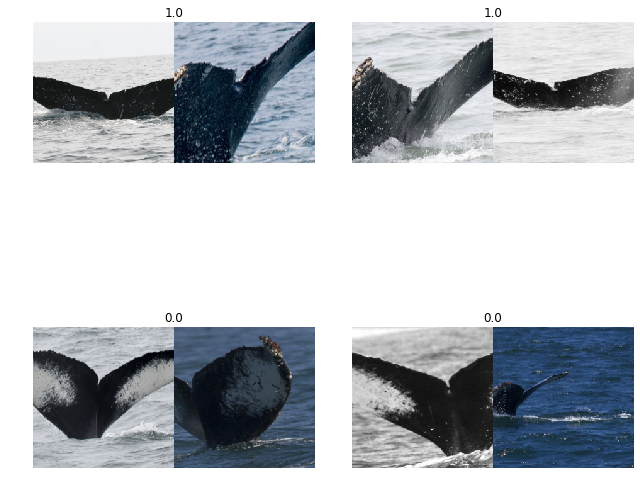

In [19]:
data.show_batch(2)

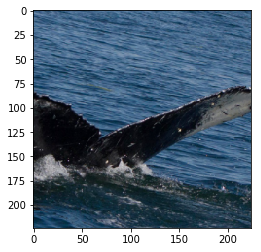

In [20]:
# Checking if the normalization done above is correct
x = next(iter(data.train_dl))
t=x[0][0][0].cpu()
to = mean[...,None,None] + t* std[...,None,None]
import torchvision
ti = torchvision.transforms.ToPILImage(to)
plt.imshow(to.numpy().transpose(1,2,0))

## Siamese network definition

In [27]:
from fastai.vision import learner

class SiameseNet(nn.Module):
    def __init__(self, arch=models.resnet18, lin_ftrs=[256, 128], emb_sz=128,ps=0.5, bn_final=False):
        super(SiameseNet, self).__init__()
        self.arch, self.emb_sz = arch, emb_sz
        self.lin_ftrs, self.ps, self.bn_final = lin_ftrs, ps, bn_final
        self.body = learner.create_body(self.arch, True, learner.cnn_config(self.arch)['cut'])
        self.head = learner.create_head(num_features_model(self.body), self.emb_sz, self.lin_ftrs, self.ps,self.bn_final)
        self.cnn = nn.Sequential(self.body, self.head)
                                  
    def forward(self, x1, x2):
        output1 = self.cnn(x1)
        output2 = self.cnn(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.cnn(x)

In [28]:
class ContrastiveLoss(nn.Module):
    """Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """
    def __init__(self, margin=5.):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, ops, target, size_average=True):
        op1, op2 = ops[0], ops[1]
        dist = F.pairwise_distance(op1, op2)
        pdist = dist*target
        ndist = dist*(1-target)
        loss = 0.5* ((pdist**2) + (F.relu(self.margin-ndist)**2))
        return loss.mean() if size_average else losses.sum()

In [29]:
model = SiameseNet().cuda()
apply_init(model.head, nn.init.kaiming_normal_)
loss_func=ContrastiveLoss().cuda()
siam_learner = Learner(data, model, loss_func=loss_func, model_dir=Path(os.getcwd()))

In [30]:
siam_learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.51E-03
Min loss divided by 10: 4.37E-02


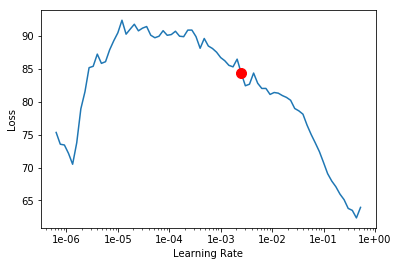

In [31]:
siam_learner.recorder.plot(suggestion=True)

In [32]:
siam_learner.fit_one_cycle(5, slice(3*1e-2))

epoch,train_loss,valid_loss,time
0,43.432365,1185.031860,00:14
1,18.787392,12.818371,00:14
2,12.578282,10.914408,00:14
3,10.604965,10.913564,00:14
4,9.863037,10.983727,00:15


In [33]:
def extract_embedding(dl, ds, mdl):
    mdl.eval()
    with torch.no_grad():
        preds = torch.zeros((len(ds), 128))
        start=0
        for cnt, (x, y) in enumerate(dl, start=0):
            size = x[0].shape[0]
            preds[start:start+size,:] = model.get_embedding(x[0])
            start+= size
        return preds

In [35]:
data = (SiamImageItemList.from_df(df=train, path=path/'train', cols=0)
         .split_by_rand_pct(valid_pct=1, seed=34)
         .label_from_df(cols=target_col, label_cls=FloatList)
         .transform(whl_tfms, size=224)
         .databunch(bs=4))

/localhome/prathmeshmadhu/.virtualenvs/dl/lib/python3.6/site-packages/fastai/data_block.py:451: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")


In [36]:
dl = data.valid_dl
ds = data.valid_ds
res = extract_embedding(dl, ds, model)
whlc=np.array([train.loc[train.Image == Path(i).name, 'Id'].values[0] for i in ds.items])

In [42]:
res.shape

torch.Size([522, 128])

In [37]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [38]:
pca.fit(res)
embs2d = pca.transform(res)

In [39]:
import colorsys
def random_colors(N, bright=True):
    # This code is borrowed from https://github.com/matterport/Mask_RCNN
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def plot_embeddings(embeddings=None,whlc=None, xlim=None, ylim=None):
# This code is borrowed from https://github.com/adambielski/siamese-triplet/blob/master/Experiments_MNIST.ipynb
    plt.figure(figsize=(10,10))
    for cnt, i in enumerate(set(whlc)):
#         print(cnt, i)
        inds = np.where(whlc==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[cnt])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(set(whlc))

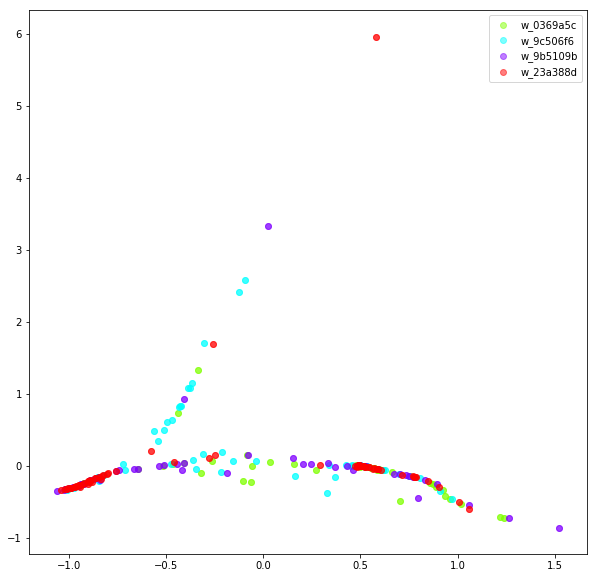

In [40]:
colors = random_colors(len(set(whlc)))
plot_embeddings(embs2d,whlc, xlim=None, ylim=None)

In [41]:
embs2d.shape

(522, 2)